# Simulate a single pendulum system

Refs: 
- https://underactuated.mit.edu/pend.html#section3
- https://tutorials.sciml.ai/html/models/01-classical_physics.html


In this notebook, I'll be deriving the equations of motion of a single pendulum. We will then map it to a multivariate first-order system, discretize the dynamics and simulate the evolution.

![](figures/simple_single_pend.svg)

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
IJulia.clear_output();

In [2]:
using Printf
using Plots
default(label="", grid=false, margin=10Plots.pt)

In [3]:
function polar2cart(z)
    "Map angles to Cartesian space"

    # Position of first mass
    x = l*sin.(z[1])
    y = l*-cos.(z[1])
    
    return (x,y)
end

polar2cart (generic function with 1 method)

## Lagrangian mechanics

Using Lagrangian mechanics, we obtain the following equations of motion:

$$\begin{align} 
ml^2 \ddot{\theta} + m g l \sin(\theta) &= 0 
\end{align}$$

We'd like to isolate the second-order derivates on one side:

$$\begin{align} 
\ddot{\theta} = - \frac{g}{l}\sin(\theta)
\end{align}$$

If we use the following variable substitutions, 

$$\begin{align}
z &= \begin{bmatrix} \theta & \dot{\theta} \end{bmatrix}^{\top} \\
\omega^2 &= \frac{g}{l} \, ,
\end{align} \, ,$$

to transform this into a multivariate first-order system:

$$\begin{align} 
\dot{z} = \begin{bmatrix} z_2 \\ - \omega^2 \sin(z_1) \end{bmatrix}
\end{align}$$

We could now introduce a small-angle approximation, $\sin(\theta) \approx \theta$, and we would end up with linear dynamics. However, if we're just simulating the evolution of the system, then there is little need for linearization in this way.

### Discretization

A simple forward Euler discretization, $\dot{z} = \frac{z_{k+1} - z_k}{\Delta t}$, yields

$$\begin{align} 
    z_{k+1} = z_{k} + \Delta t \begin{bmatrix} z_{k,2} \\ - \omega^2 \sin(z_{k,1}) \end{bmatrix} \, .
\end{align}$$

I'll be using a 4th-order Runge-Kutta method to obtain a numerical solution.

In [4]:
# Define time scales
tspan = (0.,30.)
dt = 0.05
time = tspan[1]:dt:tspan[end]
T = length(time)

601

In [5]:
# System parameters
m = 1   # kg
l = 1   # m
const G = 9.81 # N or kg*m / s^2

# Natural frequency
ω² = G/l

9.81

In [6]:
function dzdt(z,t)
   "Derivative function" 
    
    # Equations of motion
    return [z[2]; -ω²*sin(z[1])]
end

dzdt (generic function with 1 method)

In [7]:
function RK4(z,t,dt)

    K1 = dzdt(z,t)
    K2 = dzdt(z + K1*dt/2, t+dt/2)
    K3 = dzdt(z + K2*dt/2, t+dt/2)
    K4 = dzdt(z + K3*dt, t+dt)

    return dt*1/6*(K1 + 2*K2 + 2*K3 + K4)
end

RK4 (generic function with 1 method)

In [8]:
# Allocate
z_ = zeros(2,T)

# Initial state
z_0 = [π/2, 0]

# Define previous timepoint
z_tmin1 = z_0

# Time-stepping
for (ii,t) in enumerate(time)

    # Update state
    z_[:,ii] = z_tmin1 + RK4(z_tmin1,t, dt)

    # Update previous variables
    z_tmin1 = z_[:,ii]

end

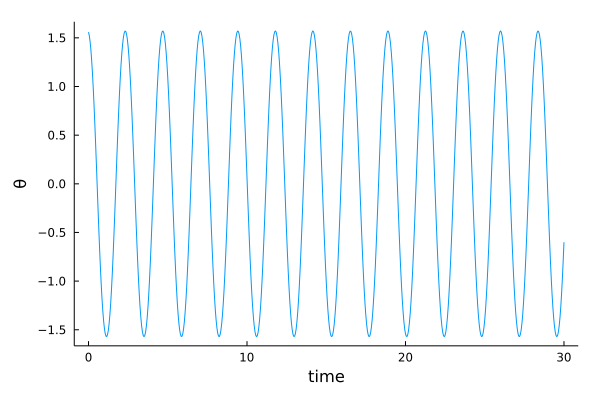

In [9]:
plot(time, z_[1,:], xlabel="time", ylabel="θ")

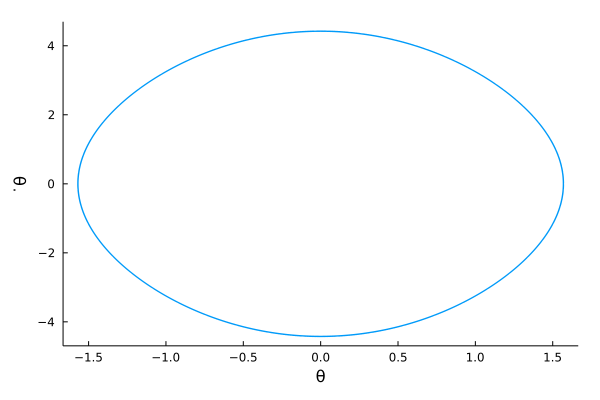

In [10]:
plot(z_[1,:], z_[2,:], xlabel="θ", ylabel="̇θ")

┌ Info: Saved animation to 
│   fn = /home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-acrobot/figures/single-pendulum.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/E2187/src/animation.jl:126


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-acrobot/figures/single-pendulum.gif")
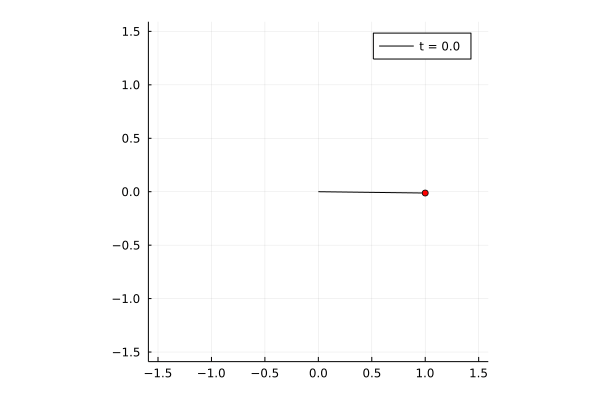

In [11]:
anim = @animate for (i,t) in enumerate(time)
   
    # Current Cartesian positions
    p1 = polar2cart(z_[:,i])
    
    # Concatenate
    pen_k = [0 0; p1[1] p1[2]]
    
    # Plot line
    plot(pen_k[:,1], pen_k[:,2], label=@sprintf("t = %.1f", t), xlims=[-1.5,1.5], ylims=[-1.5,1.5], aspect_ratio=:equal, grid=true, color="black")
    
    # Point masses
    scatter!([pen_k[2,1]], [pen_k[2,2]], color="red")
    
end
gif(anim, "figures/single-pendulum.gif", fps=100)

## DifferentialEquations

In [12]:
using DifferentialEquations

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1423


In [13]:
# Constants
const g = 9.81
L = 1.0

# Initial Conditions
u₀ = [0,π/2]
tspan = (0.0,6.3)

# Define ODE
function simple_pendulum(du,u,p,t)
    θ = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g/L)*sin(θ)
end

# Pass to solvers
prob = ODEProblem(simple_pendulum, u₀, tspan)
sol = solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 33-element Vector{Float64}:
 0.0
 0.0006362147454811361
 0.006998362200292497
 0.03660216163106764
 0.09522902219251353
 0.17748934143704403
 0.28383650348392064
 0.4185305866468124
 0.5722776127723227
 0.7241766040697459
 0.9174445901770459
 1.1209185861398787
 1.3105830097476352
 ⋮
 3.561225211001187
 3.8388019356876377
 4.105096195458151
 4.38034042869402
 4.6522983884114275
 4.920576066334854
 5.203203330734459
 5.464438017379163
 5.752593667289859
 6.003097791026381
 6.298729037342623
 6.3
u: 33-element Vector{Vector{Float64}}:
 [0.0, 1.5707963267948966]
 [0.0009993631238780826, 1.5707932081482545]
 [0.010992121372010251, 1.5704189893030465]
 [0.05736870622276341, 1.5604882542476963]
 [0.14737974825321118, 1.5015676987217075]
 [0.26471126344533463, 1.335664195671971]
 [0.38987224917706875, 0.9975316008469551]
 [0.4872545527723254, 0.4290169864879477]
 [0.4976251767078862, -0.29640876217458917]
 [0.400971

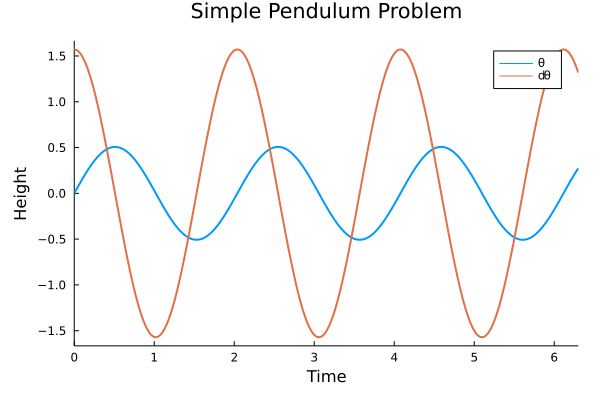

In [14]:
plot(sol,linewidth=2,title ="Simple Pendulum Problem", xaxis="Time", yaxis="Height", label=["\\theta" "d\\theta"])